In [1]:
# ===============================
# Cell 1: Imports, Config & File Paths
# ===============================

import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# -----------------------------
# Global config / hyperparameters
# -----------------------------
SEED = 42
SEQ_LENGTH = 30      # length of sequence window
BATCH_SIZE = 64      # batch size for all models
EPOCHS = 20          # default number of epochs
LR = 1e-3            # default learning rate
MODEL_DIR = "../models"  # directory to store trained models

# Set display options
pd.set_option('display.max_columns', None)

# Ensure model directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Reproducibility helper
def set_seed(seed: int = SEED) -> None:
    """Set random seeds for reproducible experiments."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# Paths (adjust if your data is inside /data/raw/)
DATA_DIR = "../data/raw/"
TRAIN_FILE = os.path.join(DATA_DIR, "train_FD001.txt")
TEST_FILE = os.path.join(DATA_DIR, "test_FD001.txt")
RUL_FILE = os.path.join(DATA_DIR, "RUL_FD001.txt")

print("📂 Looking for files...")
print("Train Exists:", os.path.exists(TRAIN_FILE))
print("Test Exists:", os.path.exists(TEST_FILE))
print("RUL Exists:", os.path.exists(RUL_FILE))

print("\n✅ Cell 1 executed successfully (Imports, Config & Paths Loaded)")

📂 Looking for files...
Train Exists: True
Test Exists: True
RUL Exists: True

✅ Cell 1 executed successfully (Imports, Config & Paths Loaded)


In [2]:
# =========================================
# Cell 2: Load train, test, and RUL datasets
# =========================================

# Define column names (CMAPSS FD001 has 26 columns)
column_names = [
    "engine_id", "cycle",
    "op_setting_1", "op_setting_2", "op_setting_3",
    "sensor_1", "sensor_2", "sensor_3", "sensor_4", "sensor_5",
    "sensor_6", "sensor_7", "sensor_8", "sensor_9", "sensor_10",
    "sensor_11", "sensor_12", "sensor_13", "sensor_14", "sensor_15",
    "sensor_16", "sensor_17", "sensor_18", "sensor_19", "sensor_20",
    "sensor_21"
]

# Load datasets
train_df = pd.read_csv(TRAIN_FILE, sep=r"\s+", header=None, names=column_names)
test_df  = pd.read_csv(TEST_FILE, sep=r"\s+", header=None, names=column_names)
rul_df   = pd.read_csv(RUL_FILE, sep=r"\s+", header=None, names=["RUL"])

# Display basic info
print("📘 Train dataset shape:", train_df.shape)
print("📘 Test dataset shape:", test_df.shape)
print("📘 RUL dataset shape:", rul_df.shape)

print("\n🔍 First 5 rows of train dataset:")
display(train_df.head())

print("\n🔍 Checking for missing values:")
print(train_df.isna().sum().sum(), "missing values found in training data")

print("\n✅ Cell 2 executed successfully (Data Loaded)")


📘 Train dataset shape: (20631, 26)
📘 Test dataset shape: (13096, 26)
📘 RUL dataset shape: (100, 1)

🔍 First 5 rows of train dataset:


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044



🔍 Checking for missing values:
0 missing values found in training data

✅ Cell 2 executed successfully (Data Loaded)


🔢 Number of engines in training set: 100
🔢 Number of engines in test set: 100

📊 Cycle statistics per engine:
Min cycles: 128
Max cycles: 362

🔍 Show first 10 engines and their max cycles:


engine_id
1     192
2     287
3     179
4     189
5     269
6     188
7     259
8     150
9     201
10    222
Name: cycle, dtype: int64

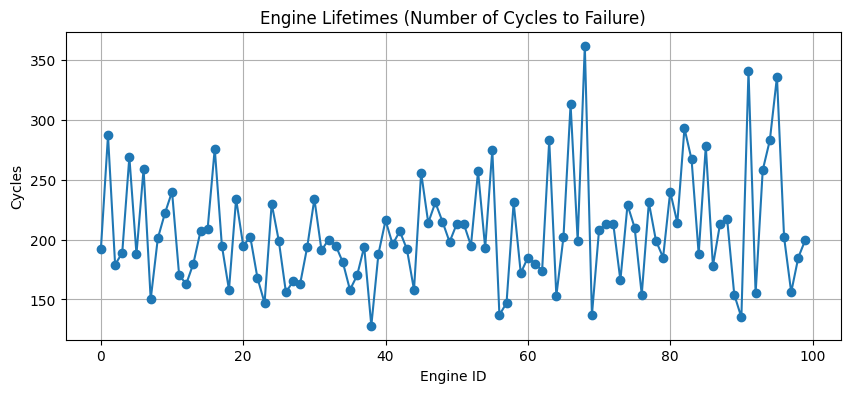


📈 Plotting sensor trend for Engine 1 (sensor_2 as example)


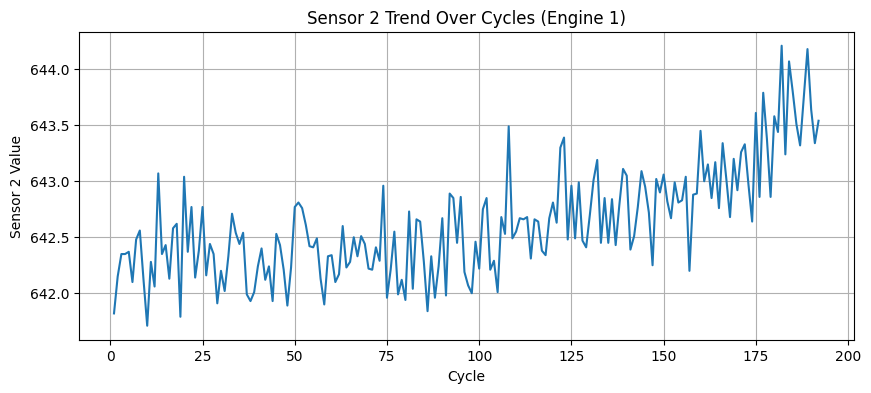

✅ Cell 3 executed successfully (Engine/Cycle Understanding Complete)


In [3]:
# =========================================
# Cell 3: Explore engine and cycle structure
# =========================================

print("🔢 Number of engines in training set:", train_df["engine_id"].nunique())
print("🔢 Number of engines in test set:", test_df["engine_id"].nunique())

# Compute cycles for each engine
engine_cycle_counts = train_df.groupby("engine_id")["cycle"].max()

print("\n📊 Cycle statistics per engine:")
print("Min cycles:", engine_cycle_counts.min())
print("Max cycles:", engine_cycle_counts.max())

print("\n🔍 Show first 10 engines and their max cycles:")
display(engine_cycle_counts.head(10))

# Plot cycle distribution
plt.figure(figsize=(10,4))
plt.plot(engine_cycle_counts.values, marker='o')
plt.title("Engine Lifetimes (Number of Cycles to Failure)")
plt.xlabel("Engine ID")
plt.ylabel("Cycles")
plt.grid(True)
plt.show()

print("\n📈 Plotting sensor trend for Engine 1 (sensor_2 as example)")

engine1 = train_df[train_df["engine_id"] == 1]

plt.figure(figsize=(10,4))
plt.plot(engine1["cycle"], engine1["sensor_2"])
plt.title("Sensor 2 Trend Over Cycles (Engine 1)")
plt.xlabel("Cycle")
plt.ylabel("Sensor 2 Value")
plt.grid(True)
plt.show()

print("✅ Cell 3 executed successfully (Engine/Cycle Understanding Complete)")

In [4]:
# =========================================
# Cell 4: Calculate RUL (Remaining Useful Life)
# =========================================

# Get max cycle per engine
max_cycles = train_df.groupby("engine_id")["cycle"].max()

# Map max cycle to each row
train_df["max_cycle"] = train_df["engine_id"].map(max_cycles)

# Calculate RUL
train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]

# Drop helper column
train_df.drop(columns=["max_cycle"], inplace=True)

print("📘 Train data with RUL added:")
display(train_df.head())

print("\n🔍 RUL statistics:")
print(train_df["RUL"].describe())

print("\n🔍 Check last rows of Engine 1:")
display(train_df[train_df["engine_id"] == 1].tail())

print("✅ Cell 4 executed successfully (RUL Calculated)")


📘 Train data with RUL added:


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187



🔍 RUL statistics:
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

🔍 Check last rows of Engine 1:


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,21.61,551.94,2388.31,9037.91,1.3,48.00,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588,4
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,21.61,550.70,2388.27,9044.55,1.3,48.08,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127,3
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,21.61,551.29,2388.29,9040.58,1.3,48.33,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675,2
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,21.61,550.92,2388.28,9042.76,1.3,48.15,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,1
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,21.61,551.25,2388.32,9033.22,1.3,48.25,520.08,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649,0


✅ Cell 4 executed successfully (RUL Calculated)


In [5]:
# =========================================
# Cell 5: Feature Scaling (Standardization)
# =========================================

from sklearn.preprocessing import StandardScaler

# Select feature columns (exclude engine_id, cycle, RUL)
feature_cols = [col for col in train_df.columns 
                if col not in ["engine_id", "cycle", "RUL"]]

print("📌 Features selected for scaling:", feature_cols)

# Initialize scaler
scaler = StandardScaler()

# Fit only on training feature columns
scaler.fit(train_df[feature_cols])

# Transform train data
train_scaled = train_df.copy()
train_scaled[feature_cols] = scaler.transform(train_df[feature_cols])

print("📘 Scaled training data preview:")
display(train_scaled.head())

# Save scaler for future inference
import joblib
joblib.dump(scaler, "scaler.pkl")

print("💾 Scaler saved as scaler.pkl")

print("✅ Cell 5 executed successfully (Features Scaled)")


📌 Features selected for scaling: ['op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']
📘 Scaled training data preview:


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.315980,-1.372953,0.0,0.0,-1.721725,-0.134255,-0.925936,-5.329071e-15,0.141683,1.121141,-0.516338,-0.862813,0.0,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-3.469447e-18,-0.781710,0.0,0.0,1.348493,1.194427,191
1,1,2,0.872722,-1.031720,0.0,0.0,-1.061780,0.211528,-0.643726,-5.329071e-15,0.141683,0.431930,-0.798093,-0.958818,0.0,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-3.469447e-18,-0.781710,0.0,0.0,1.016528,1.236922,190
2,1,3,-1.961874,1.015677,0.0,0.0,-0.661813,-0.413166,-0.525953,-5.329071e-15,0.141683,1.008155,-0.234584,-0.557139,0.0,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-3.469447e-18,-2.073094,0.0,0.0,0.739891,0.503423,189
3,1,4,0.324090,-0.008022,0.0,0.0,-0.661813,-1.261314,-0.784831,-5.329071e-15,0.141683,1.222827,0.188048,-0.713826,0.0,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-3.469447e-18,-0.781710,0.0,0.0,0.352598,0.777792,188
4,1,5,-0.864611,-0.690488,0.0,0.0,-0.621816,-1.251528,-0.301518,-5.329071e-15,0.141683,0.714393,-0.516338,-0.457059,0.0,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-3.469447e-18,-0.136018,0.0,0.0,0.463253,1.059552,187


💾 Scaler saved as scaler.pkl
✅ Cell 5 executed successfully (Features Scaled)


In [6]:
# =========================================
# Cell 6: Prepare Sequences for LSTM (Windowing)
# =========================================

# Function to create sequences for each engine
# Uses only past `SEQ_LENGTH` cycles to predict RUL at the next time step
# to avoid any future information leakage.
def generate_sequences(df, seq_len, feature_cols):
    X, y = [], []

    for engine_id in df["engine_id"].unique():
        engine_data = df[df["engine_id"] == engine_id]
        engine_array = engine_data[feature_cols].values
        rul_array = engine_data["RUL"].values

        # Sliding window over time for this engine
        for i in range(len(engine_data) - seq_len):
            X.append(engine_array[i : i + seq_len])
            y.append(rul_array[i + seq_len])

    return np.array(X), np.array(y)

print("⏳ Generating sequences...")
X_train, y_train = generate_sequences(train_scaled, SEQ_LENGTH, feature_cols)

print("📘 X_train shape:", X_train.shape)
print("📘 y_train shape:", y_train.shape)

print("✅ Cell 6 executed successfully (Sequences Prepared)")


⏳ Generating sequences...
📘 X_train shape: (17631, 30, 24)
📘 y_train shape: (17631,)
✅ Cell 6 executed successfully (Sequences Prepared)


In [7]:
# =========================================
# Cell 7: Build LSTM Model (GPU Supported)
# =========================================

import torch
import torch.nn as nn

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🔥 Using device:", device)

# Hyperparameters
input_size = X_train.shape[2]   # number of features = 24
hidden_size = 64                # number of LSTM units
num_layers = 2                  # stacked LSTMs
dropout = 0.2                   # prevent overfitting
output_size = 1                 # predict RUL

class RUL_LSTM(nn.Module):
    """LSTM-based regressor for Remaining Useful Life (RUL)."""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        out = self.fc(out)
        return out

# Initialize model
model = RUL_LSTM(input_size, hidden_size, num_layers, output_size, dropout).to(device)
print(model)

print("✅ Cell 7 executed successfully (LSTM Model Built)")

🔥 Using device: cuda
RUL_LSTM(
  (lstm): LSTM(24, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
✅ Cell 7 executed successfully (LSTM Model Built)


Epoch 1/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [1/20] Loss: 10438.7834


Epoch 2/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [2/20] Loss: 7852.6581


Epoch 3/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [3/20] Loss: 6030.9604


Epoch 4/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [4/20] Loss: 4681.1597


Epoch 5/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [5/20] Loss: 3676.4366


Epoch 6/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [6/20] Loss: 2929.3097


Epoch 7/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [7/20] Loss: 2380.6746


Epoch 8/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [8/20] Loss: 1967.0016


Epoch 9/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [9/20] Loss: 1655.1111


Epoch 10/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [10/20] Loss: 1415.9409


Epoch 11/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [11/20] Loss: 1244.0088


Epoch 12/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [12/20] Loss: 1099.0016


Epoch 13/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [13/20] Loss: 985.8402


Epoch 14/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [14/20] Loss: 895.7677


Epoch 15/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [15/20] Loss: 827.1378


Epoch 16/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [16/20] Loss: 759.1896


Epoch 17/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [17/20] Loss: 705.2815


Epoch 18/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [18/20] Loss: 655.5911


Epoch 19/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [19/20] Loss: 600.0921


Epoch 20/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [20/20] Loss: 544.5355


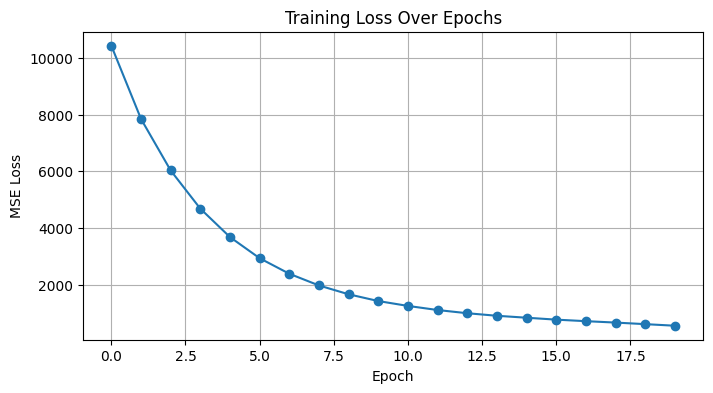

💾 Model saved as ../models\rul_lstm.pth
✅ Cell 8 executed successfully (Training Complete)


In [8]:
# =========================================
# Cell 8: PyTorch DataLoader + Training Loop
# =========================================

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm

# ----------------------------
# Convert numpy to PyTorch tensors
# ----------------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

# ----------------------------
# Create DataLoader
# ----------------------------
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# ----------------------------
# Loss + Optimizer
# ----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ----------------------------
# Training Loop
# ----------------------------
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {epoch_loss:.4f}")

# ----------------------------
# Plot training loss
# ----------------------------
plt.figure(figsize=(8, 4))
plt.plot(loss_history, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

# ----------------------------
# Save trained model
# ----------------------------
model_path = os.path.join(MODEL_DIR, "rul_lstm.pth")
torch.save(model.state_dict(), model_path)
print(f"💾 Model saved as {model_path}")

print("✅ Cell 8 executed successfully (Training Complete)")


📊 Test RMSE: 24.04
📊 Test MAE: 16.81


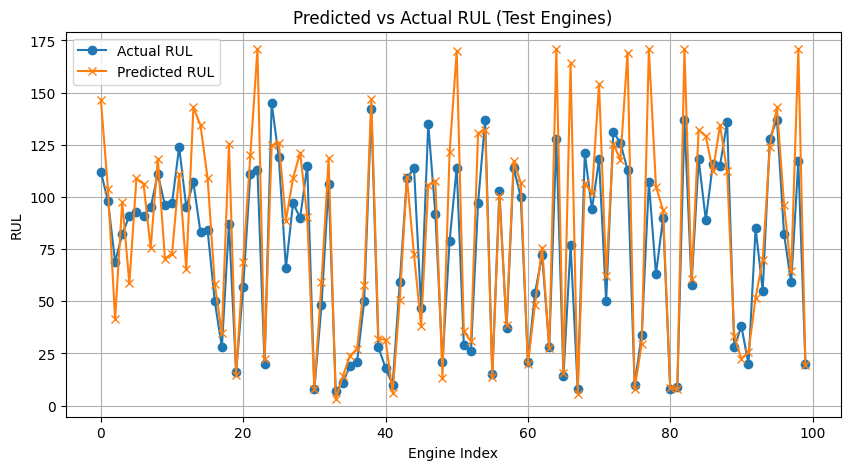

✅ Cell 9 executed successfully (Test Evaluation Complete)


In [9]:
# =========================================
# Cell 9: Evaluate LSTM on Test Data
# =========================================

# Load scaler
import joblib
scaler = joblib.load("scaler.pkl")

# Load test data
test_df = pd.read_csv(TEST_FILE, sep=r"\s+", header=None, names=train_df.columns[:-1])  # exclude RUL
rul_df = pd.read_csv(RUL_FILE, sep=r"\s+", header=None, names=["RUL"])

# Scale features
test_scaled = test_df.copy()
test_scaled[feature_cols] = scaler.transform(test_df[feature_cols])

# Generate sequences for test
SEQ_LENGTH = 30  # same as training

def generate_test_sequences(df, seq_len, feature_cols, rul_df):
    X_test, y_test = [], []
    engine_ids = df["engine_id"].unique()
    
    for i, engine_id in enumerate(engine_ids):
        engine_data = df[df["engine_id"] == engine_id]
        engine_array = engine_data[feature_cols].values
        max_cycle = engine_data["cycle"].max()
        # Only last seq_len cycles to predict final RUL
        if len(engine_array) >= seq_len:
            X_test.append(engine_array[-seq_len:])
        else:  # pad if not enough cycles
            pad = np.zeros((seq_len - len(engine_array), len(feature_cols)))
            X_test.append(np.vstack([pad, engine_array]))
        # Actual RUL from RUL_FD001.txt
        y_test.append(rul_df.iloc[i,0])
        
    return np.array(X_test), np.array(y_test)

X_test, y_test = generate_test_sequences(test_scaled, SEQ_LENGTH, feature_cols, rul_df)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1).to(device)

# Model evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"📊 Test RMSE: {rmse:.2f}")
print(f"📊 Test MAE: {mae:.2f}")

# Plot predicted vs actual RUL
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual RUL", marker='o')
plt.plot(y_pred, label="Predicted RUL", marker='x')
plt.title("Predicted vs Actual RUL (Test Engines)")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()

print("✅ Cell 9 executed successfully (Test Evaluation Complete)")


In [10]:
# =========================================
# Cell 10a: Bi-directional LSTM Model
# =========================================

import torch.nn as nn

class RUL_BiLSTM(nn.Module):
    """Bi-directional LSTM regressor for Remaining Useful Life (RUL)."""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,  # BiLSTM
        )

        # *2 because bidirectional (forward + backward)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        out = self.fc(out)
        return out

# Initialize BiLSTM
bi_model = RUL_BiLSTM(input_size, hidden_size, num_layers, output_size, dropout).to(device)
print(bi_model)
print("✅ BiLSTM model ready for training")


RUL_BiLSTM(
  (lstm): LSTM(24, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
✅ BiLSTM model ready for training


In [11]:
# =========================================
# Cell 10b: GRU Model
# =========================================

class RUL_GRU(nn.Module):
    """GRU-based regressor for Remaining Useful Life (RUL)."""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super().__init__()

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Initialize GRU
gru_model = RUL_GRU(input_size, hidden_size, num_layers, output_size, dropout).to(device)
print(gru_model)
print("✅ GRU model ready for training")


RUL_GRU(
  (gru): GRU(24, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
✅ GRU model ready for training


Epoch 1/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [1/20] Loss: 9250.5429


Epoch 2/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [2/20] Loss: 5570.1708


Epoch 3/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [3/20] Loss: 3601.9359


Epoch 4/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [4/20] Loss: 2465.3775


Epoch 5/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [5/20] Loss: 1819.9521


Epoch 6/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [6/20] Loss: 1430.6944


Epoch 7/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [7/20] Loss: 1206.5490


Epoch 8/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [8/20] Loss: 1053.5240


Epoch 9/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [9/20] Loss: 951.8425


Epoch 10/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [10/20] Loss: 904.2465


Epoch 11/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [11/20] Loss: 852.7577


Epoch 12/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [12/20] Loss: 780.6430


Epoch 13/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [13/20] Loss: 746.4914


Epoch 14/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [14/20] Loss: 693.5933


Epoch 15/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [15/20] Loss: 649.1717


Epoch 16/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [16/20] Loss: 616.9798


Epoch 17/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [17/20] Loss: 572.2495


Epoch 18/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [18/20] Loss: 507.6092


Epoch 19/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [19/20] Loss: 445.7970


Epoch 20/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [20/20] Loss: 401.7526


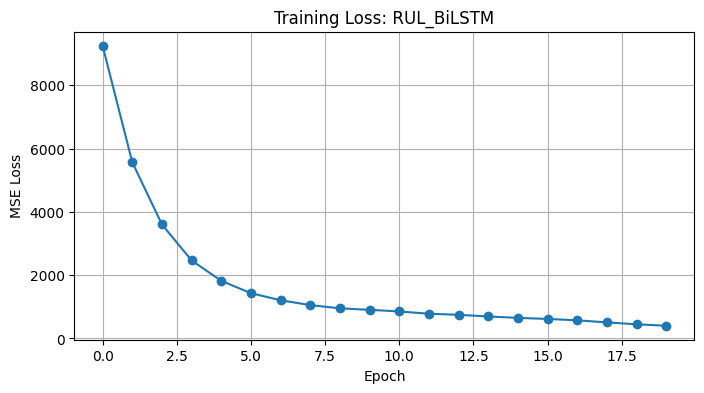

💾 BiLSTM saved as ../models\bi_lstm.pth


Epoch 1/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [1/20] Loss: 10294.3276


Epoch 2/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [2/20] Loss: 7718.2624


Epoch 3/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [3/20] Loss: 5903.0249


Epoch 4/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [4/20] Loss: 4566.5938


Epoch 5/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [5/20] Loss: 3574.6101


Epoch 6/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [6/20] Loss: 2841.1528


Epoch 7/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [7/20] Loss: 2298.3534


Epoch 8/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [8/20] Loss: 1898.4482


Epoch 9/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [9/20] Loss: 1602.0598


Epoch 10/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [10/20] Loss: 1376.2813


Epoch 11/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [11/20] Loss: 1195.2334


Epoch 12/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [12/20] Loss: 1067.7792


Epoch 13/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [13/20] Loss: 962.1743


Epoch 14/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [14/20] Loss: 882.3484


Epoch 15/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [15/20] Loss: 802.9174


Epoch 16/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [16/20] Loss: 734.2871


Epoch 17/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [17/20] Loss: 660.3584


Epoch 18/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [18/20] Loss: 580.0029


Epoch 19/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [19/20] Loss: 506.5962


Epoch 20/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [20/20] Loss: 430.1715


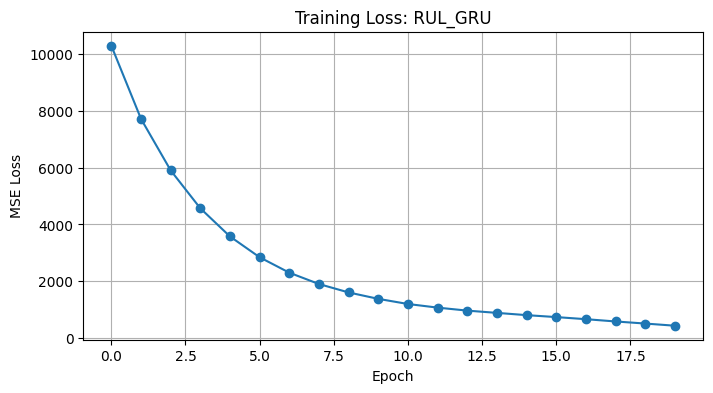

💾 GRU saved as ../models\gru.pth
✅ Cell 12 executed successfully (BiLSTM & GRU trained)


In [12]:
# =========================================
# Cell 12: Generic Training Function
# =========================================

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm.notebook import tqdm

def train_model(
    model,
    X_train,
    y_train,
    device,
    epochs: int = EPOCHS,
    batch_size: int = BATCH_SIZE,
    lr: float = LR,
):
    """Generic PyTorch training loop for sequence models (LSTM / BiLSTM / GRU / Transformer).

    Parameters
    ----------
    model : torch.nn.Module
        Model to train.
    X_train : np.ndarray
        Training inputs of shape (n_samples, seq_len, n_features).
    y_train : np.ndarray
        Training targets of shape (n_samples,).
    device : torch.device
        CPU or GPU device.
    epochs : int, optional
        Number of training epochs, by default EPOCHS.
    batch_size : int, optional
        Batch size, by default BATCH_SIZE.
    lr : float, optional
        Learning rate, by default LR.
    """
    # Convert numpy to tensors
    X_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

    # DataLoader
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    loss_history = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(loader.dataset)
        loss_history.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}")

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(loss_history, marker='o')
    plt.title(f"Training Loss: {model.__class__.__name__}")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.show()

    return model, loss_history

# =========================================
# Example: Train BiLSTM
# =========================================
bi_model, bi_loss = train_model(bi_model, X_train, y_train, device)

# Save model
bi_model_path = os.path.join(MODEL_DIR, "bi_lstm.pth")
torch.save(bi_model.state_dict(), bi_model_path)
print(f"💾 BiLSTM saved as {bi_model_path}")

# =========================================
# Example: Train GRU
# =========================================
gru_model, gru_loss = train_model(gru_model, X_train, y_train, device)

# Save model
gru_model_path = os.path.join(MODEL_DIR, "gru.pth")
torch.save(gru_model.state_dict(), gru_model_path)
print(f"💾 GRU saved as {gru_model_path}")

print("✅ Cell 12 executed successfully (BiLSTM & GRU trained)")


In [13]:
# =========================================
# Cell 13: Evaluation Helper (No Plots Here)
# =========================================

from sklearn.metrics import mean_squared_error, mean_absolute_error


def evaluate_model(model, X_test, y_test, device):
    """Run inference on X_test and compute RMSE/MAE.

    This is a reusable helper; plotting and printing are handled
    in the final comparison cell to avoid duplication.
    """
    model.eval()
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)
    with torch.no_grad():
        y_pred = model(X_tensor).cpu().numpy()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return y_pred, rmse, mae


print("✅ Cell 13 executed successfully (Evaluation helper defined)")


✅ Cell 13 executed successfully (Evaluation helper defined)


In [14]:
# =========================================
# Cell 14: Transformer Encoder Model
# =========================================

import torch.nn as nn

class RUL_Transformer(nn.Module):
    def __init__(self, input_size, seq_len=30, dim_model=128, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.2):
        super().__init__()
        self.seq_len = seq_len
        
        # Project input features to model dimension
        self.input_proj = nn.Linear(input_size, dim_model)
        
        # Learnable positional encoding
        self.pos_encoder = nn.Parameter(torch.zeros(1, seq_len, dim_model))
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Regression head
        self.fc = nn.Linear(dim_model, 1)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        x = self.input_proj(x) + self.pos_encoder  # Add positional encoding
        x = self.transformer_encoder(x)
        x = x[:, -1, :]  # Take the last time step
        return self.fc(x)

# Initialize Transformer
transformer_model = RUL_Transformer(input_size=X_train.shape[2], seq_len=X_train.shape[1]).to(device)
print(transformer_model)
print("✅ Transformer Encoder model ready for training")


RUL_Transformer(
  (input_proj): Linear(in_features=24, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
✅ Transformer Encoder model ready for training


Epoch 1/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [1/20] Loss: 7863.2694


Epoch 2/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [2/20] Loss: 2323.5418


Epoch 3/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [3/20] Loss: 1165.5576


Epoch 4/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [4/20] Loss: 950.2160


Epoch 5/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [5/20] Loss: 853.9451


Epoch 6/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [6/20] Loss: 782.2904


Epoch 7/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [7/20] Loss: 663.9566


Epoch 8/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [8/20] Loss: 558.3417


Epoch 9/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [9/20] Loss: 429.2412


Epoch 10/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [10/20] Loss: 349.6939


Epoch 11/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [11/20] Loss: 295.2217


Epoch 12/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [12/20] Loss: 259.5291


Epoch 13/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [13/20] Loss: 253.3579


Epoch 14/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [14/20] Loss: 204.2297


Epoch 15/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [15/20] Loss: 189.4453


Epoch 16/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [16/20] Loss: 182.3086


Epoch 17/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [17/20] Loss: 148.2691


Epoch 18/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [18/20] Loss: 148.2490


Epoch 19/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [19/20] Loss: 155.4421


Epoch 20/20:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch [20/20] Loss: 125.5647


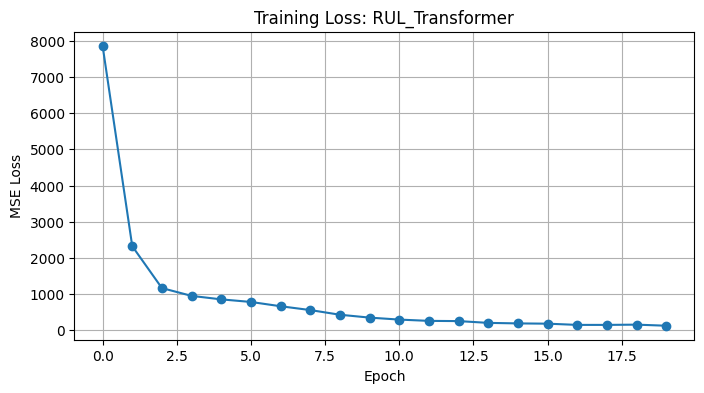

💾 Transformer Encoder saved as ../models\transformer_rul.pth


In [15]:
# =========================================
# Cell 15: Train Transformer Model
# =========================================

# Reuse the generic training function from Cell 12
transformer_model, trans_loss = train_model(
    transformer_model,
    X_train,
    y_train,
    device,
)

# Save model
transformer_model_path = os.path.join(MODEL_DIR, "transformer_rul.pth")
torch.save(transformer_model.state_dict(), transformer_model_path)
print(f"💾 Transformer Encoder saved as {transformer_model_path}")


📊 Model Comparison (Test Set)
LSTM        → RMSE: 24.04, MAE: 16.81
BiLSTM      → RMSE: 26.72, MAE: 18.13
GRU         → RMSE: 25.07, MAE: 18.42
Transformer → RMSE: 28.13, MAE: 20.04


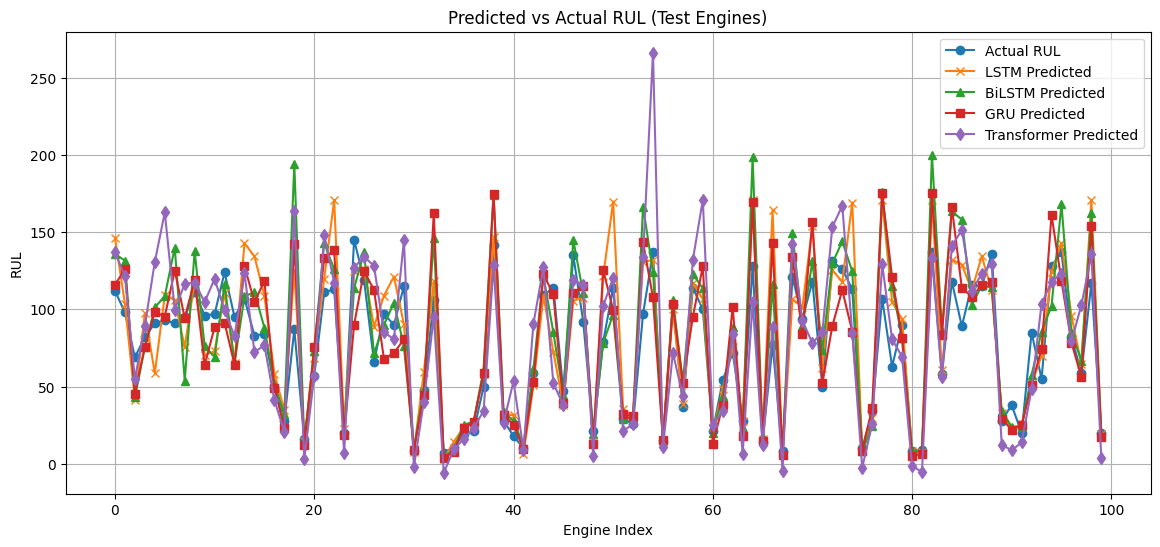

✅ Cell 16 executed successfully (All Models Evaluated & Compared)


In [16]:
# =========================================
# Cell 16: Evaluate & Compare LSTM, BiLSTM, GRU, Transformer
# =========================================

# Evaluate all models on the same test set
lstm_pred, lstm_rmse, lstm_mae = evaluate_model(model, X_test, y_test, device)
bi_pred, bi_rmse, bi_mae = evaluate_model(bi_model, X_test, y_test, device)
gru_pred, gru_rmse, gru_mae = evaluate_model(gru_model, X_test, y_test, device)
trans_pred, trans_rmse, trans_mae = evaluate_model(transformer_model, X_test, y_test, device)

# Print comparison table
print("📊 Model Comparison (Test Set)")
print(f"LSTM        → RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")
print(f"BiLSTM      → RMSE: {bi_rmse:.2f}, MAE: {bi_mae:.2f}")
print(f"GRU         → RMSE: {gru_rmse:.2f}, MAE: {gru_mae:.2f}")
print(f"Transformer → RMSE: {trans_rmse:.2f}, MAE: {trans_mae:.2f}")

# Plot Predicted vs Actual
plt.figure(figsize=(14, 6))
plt.plot(y_test, label="Actual RUL", marker='o')
plt.plot(lstm_pred, label="LSTM Predicted", marker='x')
plt.plot(bi_pred, label="BiLSTM Predicted", marker='^')
plt.plot(gru_pred, label="GRU Predicted", marker='s')
plt.plot(trans_pred, label="Transformer Predicted", marker='d')
plt.title("Predicted vs Actual RUL (Test Engines)")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()

print("✅ Cell 16 executed successfully (All Models Evaluated & Compared)")
